# Looking at MCMC chains

In this tutorial we will first generate chains for a simple model from the `cobaya` [quickstart guide](https://cobaya.readthedocs.io/en/latest/example.html).

In [7]:
info = {
    "likelihood": {
        "gaussian_mixture": {
            "means": [0.2, 0],
            "covs": [[0.1, 0.05], [0.05, 0.2]],
        }
    },
    "params": {
        "a": {"prior": {"min": -0.5, "max": 3}, "latex": r"\alpha"},
        "b": {
            "prior": {"dist": "norm", "loc": 0, "scale": 1},
            "ref": 0,
            "proposal": 0.5,
            "latex": r"\beta",
        },
    },
    "sampler": {"mcmc": None},
    "output": "chains/mcmc",
}
from cobaya.yaml import yaml_dump_file

yaml_dump_file("gaussian_mixture.yml", info, error_if_exists=False)

Running the `cobaya` Monte-Carlo Markov Chains (MCMC) sampler will be pretty fast for such simple example.

In [2]:
from cobaya.run import run

updated_info, sampler = run(info)

[output] Output to be read-from/written-into folder 'chains', with prefix 'mcmc'
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {gaussian_mixture: 17800.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: a:-0.09784318, b:0
[mcmc] Sampling!
[mcmc] Progress @ 2022-12-02 12:59:52 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.171
[mcmc]  - Convergence of means: R-1 = 0.388892 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[

We can now investigate how the parameters `a` and `b` for this Gaussian mixture likelihood have evolved. We first set the plot aesthetics *via* the `set_style` function from `cobaya_utilities.plots` module. By default, `cobaya_utilities` uses [`seaborn`](https://seaborn.pydata.org) colors and theme scheme but you can get back to default `matplotlib` style by setting `use_seaborn=False`

In [3]:
from cobaya_utilities import plots

plots.set_style()

 The `cobaya_utilities.tools` module allows to plot chains variation over MCMC steps.

[root] *WARNING* outlier fraction 0.07857142857142857 


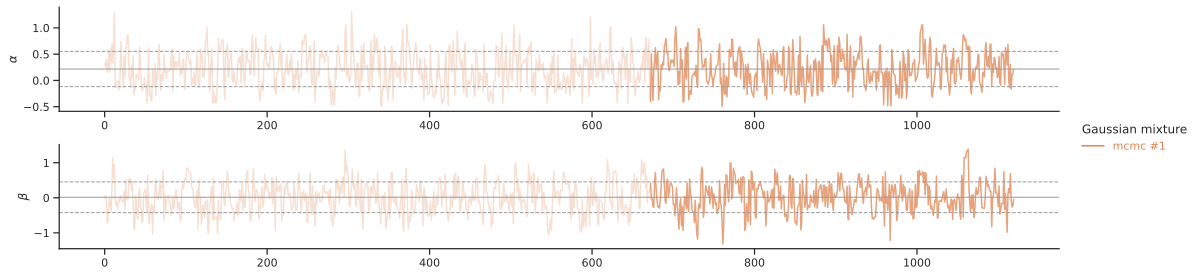

In [4]:
from cobaya_utilities import tools

mcmc_samples = {"Gaussian mixture": "chains"}
params = ["a", "b"]
tools.plot_chains(mcmc_samples, params, ncol=1);

The `plot_chains` function takes a python dictionary holding the name of the MCMC and the path location to MCMC chains. You can select which sampled parameters you want to show and you can also tweak the figure layout (here the number of columns is set to 1). The gray lines represent the mean value (solid line) and the standard deviation (dashed lines) of the parameters for the full data chain. The shaded part of the chain corresponds to a typical 40% burnin but can be changed with the `highlight_burnin` parameters (default to 0.4).

You can also plot the chain progress in terms of acceptance rate and Gelman $R-1$ parameter (as reminder `cobaya` already provides such monitoring [tool](https://cobaya.readthedocs.io/en/latest/sampler_mcmc.html#progress-monitoring) but we will see later how, in special running, the `plot_chains` function is more versatile to the default `cobaya`'s one)

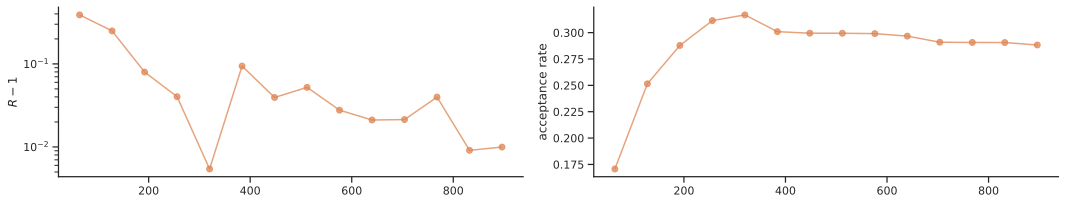

In [5]:
tools.plot_progress(mcmc_samples);

We can finally print the mean and $\sigma$ values extracted from `getdist` and showed in a `pandas Dataframe` 

In [6]:
from getdist.plots import loadMCSamples

tools.print_results(
    [loadMCSamples(f"{path}/mcmc") for path in mcmc_samples.values()],
    params=params,
    labels=mcmc_samples,
)

,$\alpha$,$\beta$
Gaussian mixture,$ 0.20^{+0.32}_{-0.37}$,$ 0.03\pm 0.41$


## Running several MCMC chains

In the most common use case, MCMC are run in cluster machines and the usual way is to run several chains with different starting points in parallel. If you have `mpi` installed you can follow the `cobaya` [guide](https://cobaya.readthedocs.io/en/latest/installation.html#mpi-parallelization-optional-but-encouraged). If you have no access or a limited one to `mpi` machines (for instance, [CC-IN2P3](https://cc.in2p3.fr) cluster has poor support for `mpi` jobs), you can run separate and independant chains as follow

In [11]:
%%bash
rm -rf chains/*
for i in {1..4}; do 
    cobaya-run -o chains/mcmc.${i} gaussian_mixture.yml > chains/mcmc.${i}.log 
done

with the resulting plots

Create MCMC symlinks...
[root] *WARNING* outlier fraction 0.00390625 
[root] *WARNING* outlier fraction 0.04632352941176471 
[root] *WARNING* outlier fraction 0.025595238095238095 
[root] *WARNING* outlier fraction 0.0002403846153846154 


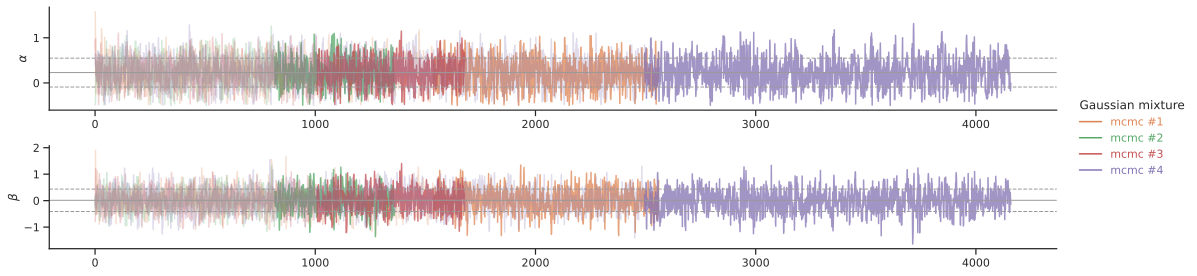

In [12]:
tools.plot_chains(mcmc_samples, params, ncol=1);

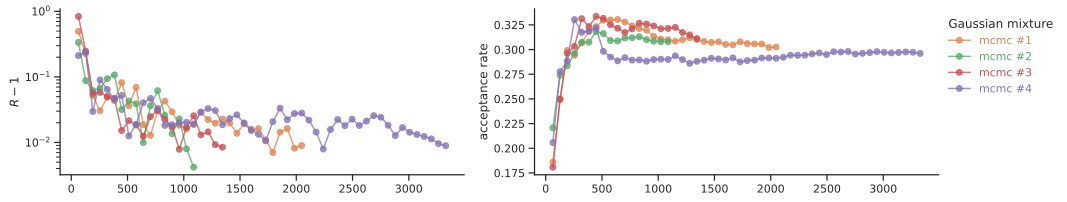

In [13]:
tools.plot_progress(mcmc_samples);

Finally, for getting some statistics of the different MCMC, `cobaya_utilities` provides a function named `print_chains_size` which return a `pandas Dataframe` with different informations such as the accepted and total steps, the corresponding rate and $R-1$ value. The `print_chains_size` function actually parsed the logfile `mcmc.?.log` which stores the printed output from `cobaya-run` execution. For such simple example, there is not a lot to learn since the convergence is almost immediate but, for longer MCMC runs (see below), this is another way to monitor your MCMC flow.

In [14]:
tools.print_chains_size(mcmc_samples)

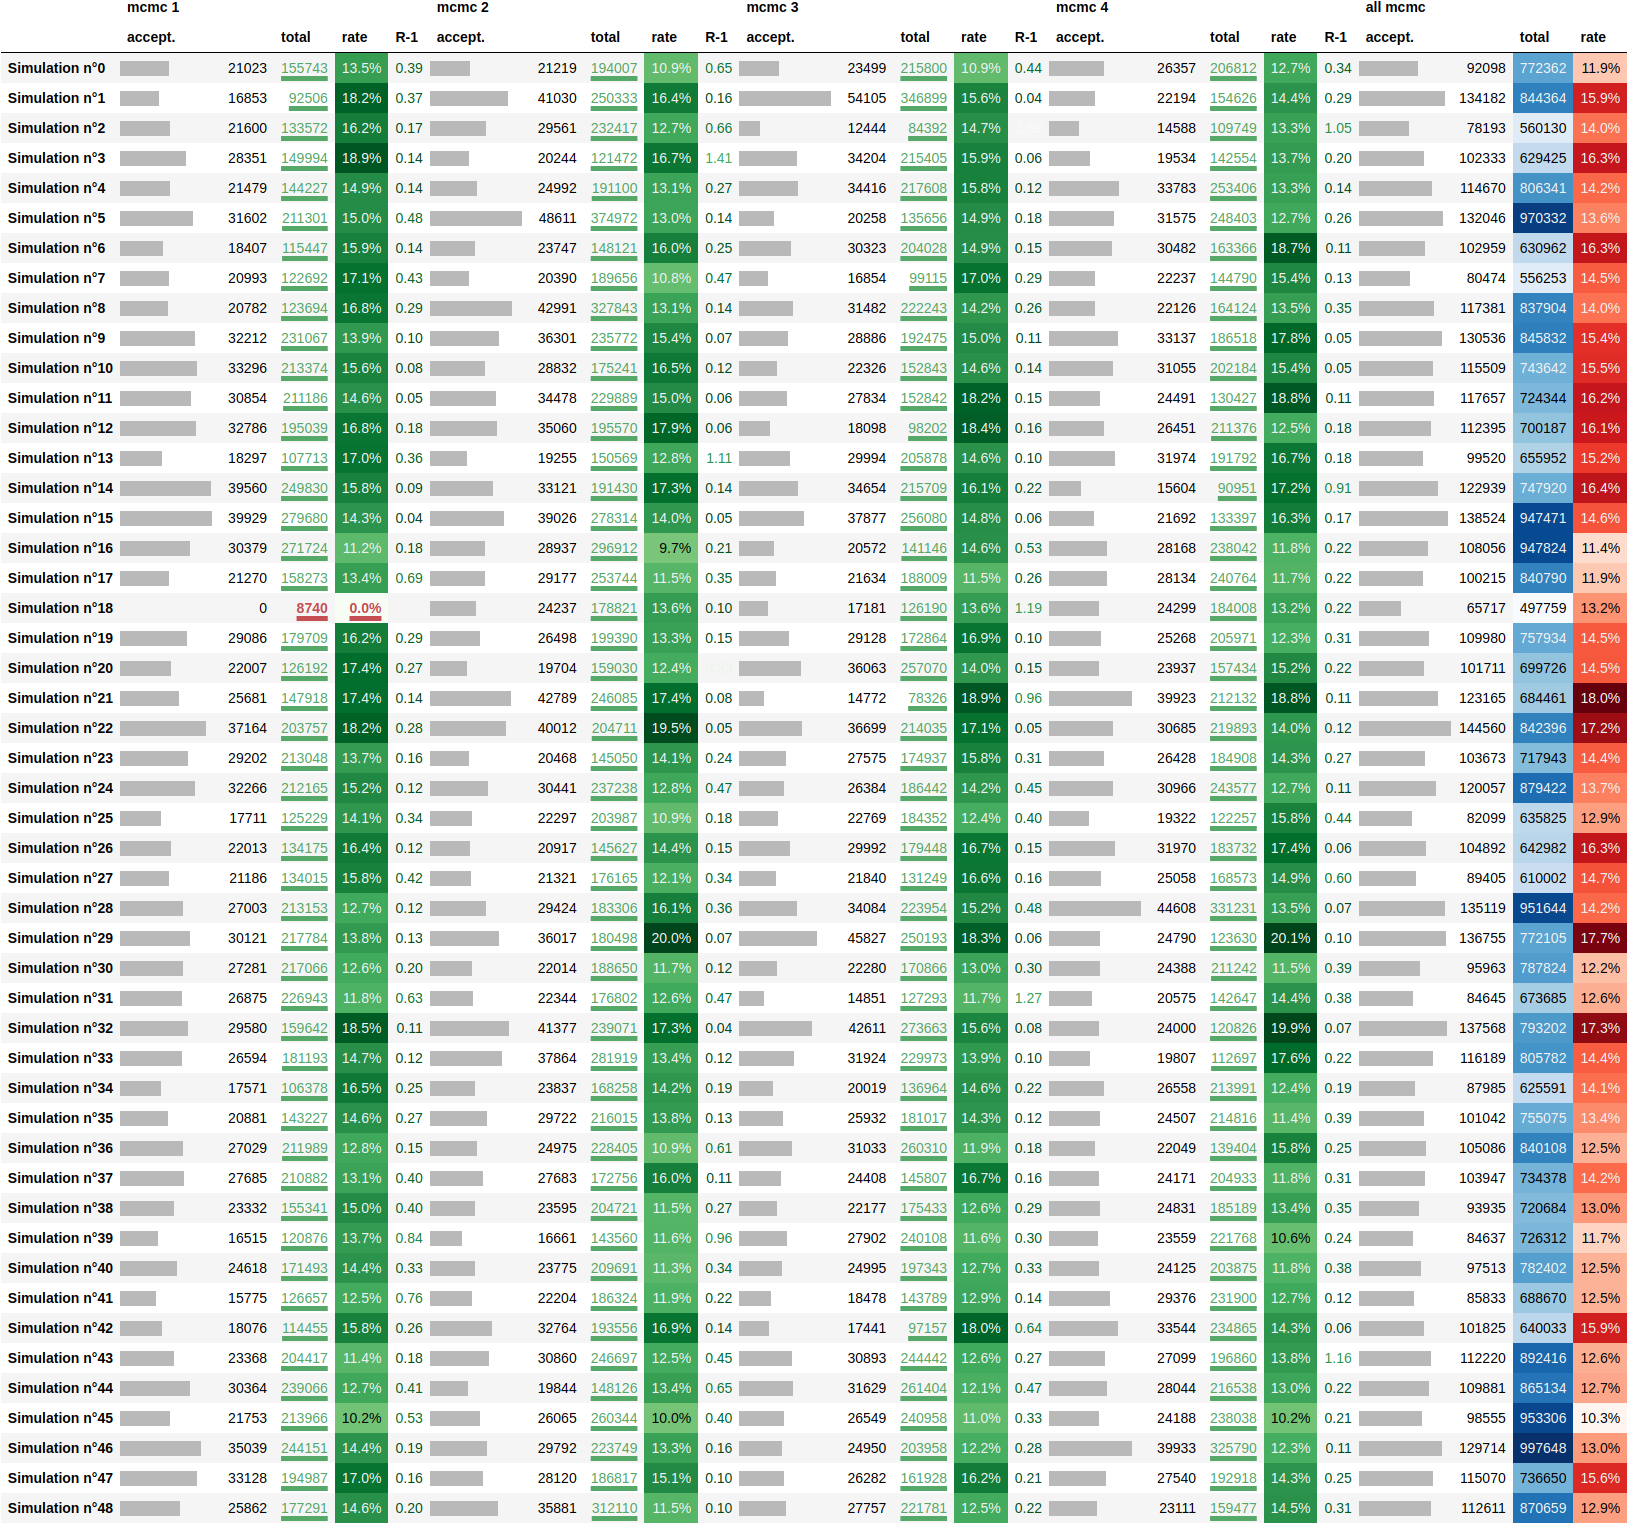

In [12]:
from IPython.display import Image

Image(filename="figures/print_chains_size.png")